In [116]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sqlite3

### EDA

In [230]:
# Import file
df = pd.read_csv('https://raw.githubusercontent.com/OscarG-DataSci/ADS-599B/main/Data%20Folder/elpac.csv')

In [118]:
# Convert date fields to datetime
df['DOB'] =  pd.to_datetime(df.DOB)
df['TestDate'] =  pd.to_datetime(df.TestDate)

In [119]:
# Missing data value counts by AcademicYear
# Most missing data is from when the pandemic quarantine went into effect, March, 2020
# The 2020-2021 school year also has many students who did not test due to distance learning, making it difficult to test all students
df[(df.TestDate.isna() == True)]['AcademicYear'].value_counts().sort_index(ascending=False)

2020-2021     858
2019-2020    1255
2018-2019      46
Name: AcademicYear, dtype: int64

In [120]:
# Initial view of shape and missing data
print("Shape: ",df.shape,"\n")

# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')

Shape:  (11669, 24) 



,Missing
TestAge,2159
TestDayName,2159
TestDate,2159
AttendedPct,3
GradeAttendedPct,3


In [121]:
# Re-load data omitting missing data
df = df[(df.TestDate.isna() == False)]

print("Shape: ",df.shape,"\n")

# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')

Shape:  (9510, 24) 



,Missing
AttendedPct,2
GradeAttendedPct,2


In [122]:
# Repeat...to verify no more data is missing
df = df[(df.AttendedPct.isna() == False)]

print("Shape: ",df.shape,"\n")

# Columns missing data
df.isnull().sum().to_frame(name='Missing').query('Missing > 0')

Shape:  (9508, 24) 



,Missing


In [123]:
# Identify features that are object dtype, to create dummy variables for
df.select_dtypes(include='object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9508 entries, 0 to 11668
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   AcademicYear       9508 non-null   object
 1   StudentGender      9508 non-null   object
 2   StudentEthnicity   9508 non-null   object
 3   Special_Education  9508 non-null   object
 4   Homeless           9508 non-null   object
 5   SocioEconomically  9508 non-null   object
 6   TestDayName        9508 non-null   object
 7   TeacherGender      9508 non-null   object
 8   TeacherEthnicity   9508 non-null   object
dtypes: object(9)
memory usage: 742.8+ KB


In [12]:
# Create dummy values from 'object' data types to get correlation values
df2 = pd.get_dummies(df, columns=['AcademicYear', 'StudentGender', 'StudentEthnicity', 'Special_Education', 'Homeless', 'SocioEconomically', 'TestDayName', 'TeacherGender', 'TeacherEthnicity'])

In [13]:
# Correlation for dummy variables for Overall Score
cor = pd.DataFrame(df2.corrwith(df2['OverallScore']))
cor.columns = ['Correlation']
cor.head(20).sort_values('Correlation', ascending=False).style.bar(align="mid", color=["red", "lightgreen"])

,Correlation
OverallScore,1.000000
OverallLevel,0.527654
GradeAttendedPct,0.264209
TestAge,0.260976
GradeEnrolledPct,0.259709
GradeLevel,0.258578
AttendedPct,0.150699
DaysAttended,0.146288
AcademicYear_2020-2021,0.074529
School_deID,0.069009


In [37]:
# Correlation for dummy variables for Overall Level
cor = pd.DataFrame(df2.corrwith(df2['OverallLevel']))
cor.columns = ['Correlation']
cor.head(20).sort_values('Correlation', ascending=False).style.bar(align="mid", color=["red", "lightgreen"])

,Correlation
OverallLevel,1.000000
OverallScore,0.527654
AcademicYear_2017-2018,0.148799
DaysAttended,0.092801
AttendedPct,0.089615
StudentGender_F,0.083854
EnrolledPct,0.047493
ExpectedAttendanceDays,0.047493
School_deID,0.043082
AcademicYear_2018-2019,0.037876


<AxesSubplot:>

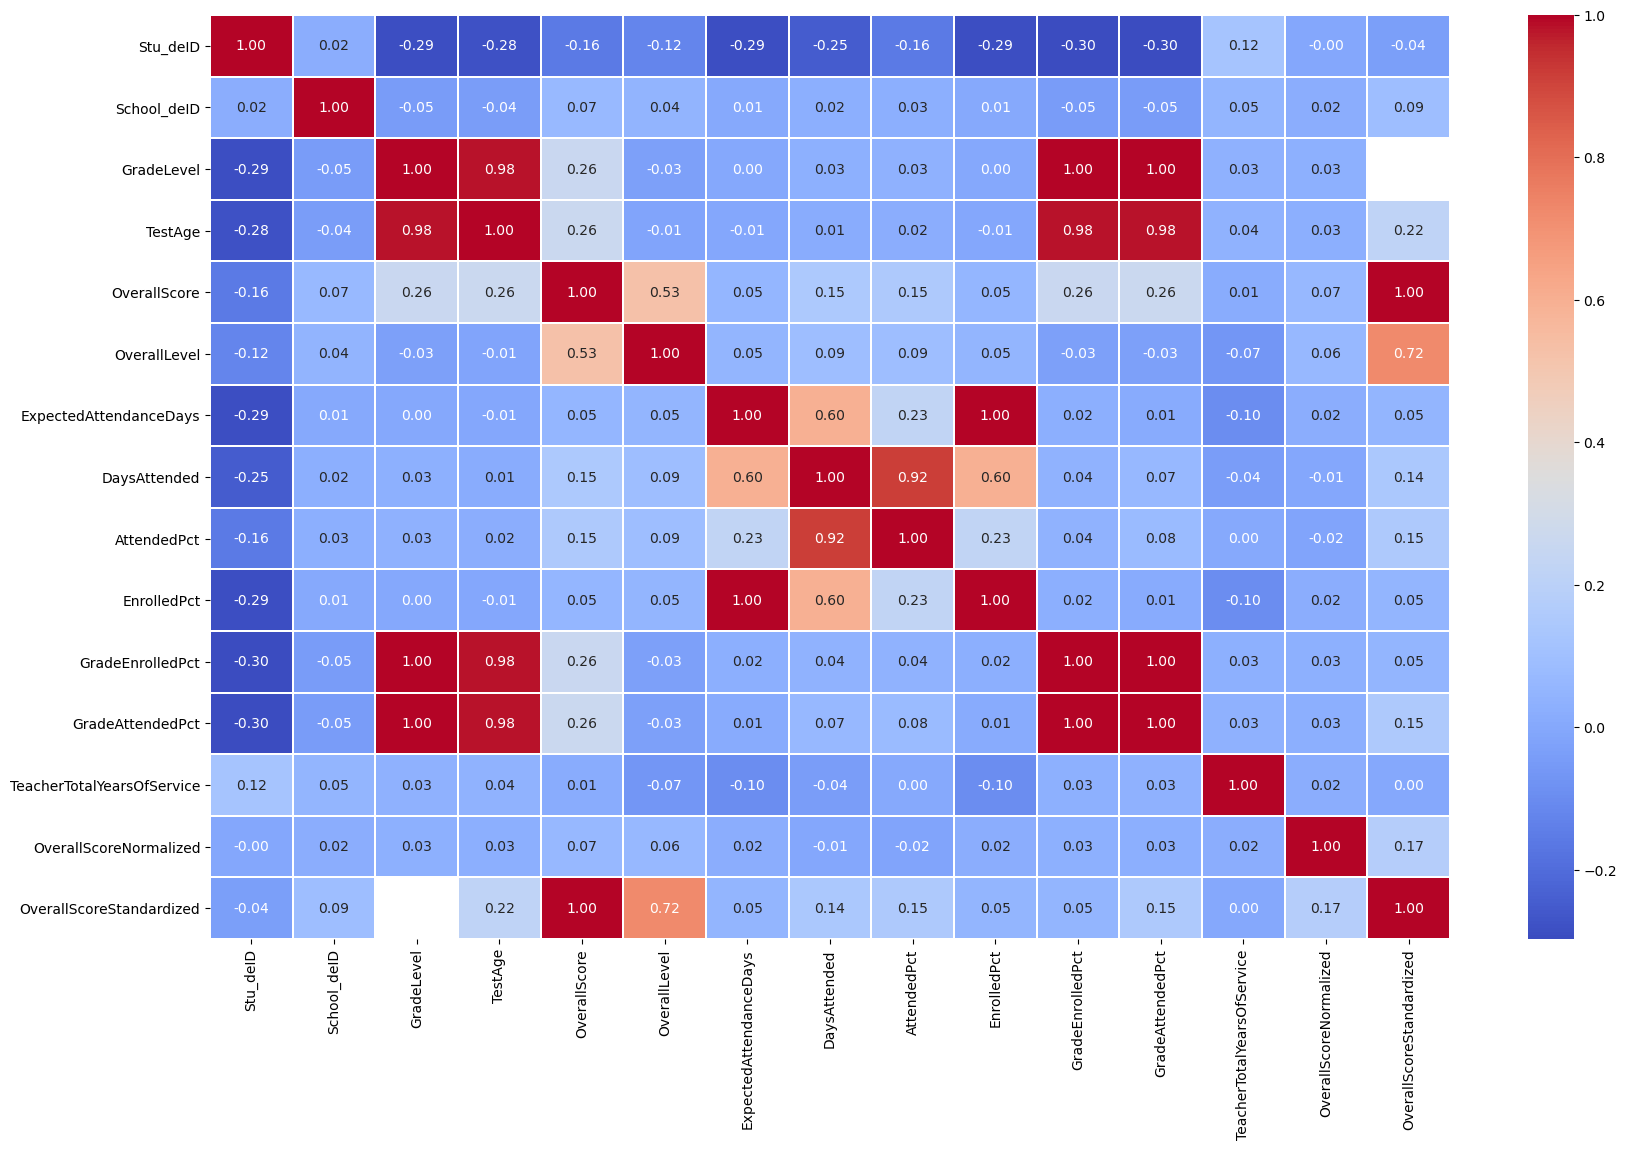

In [170]:
# Correlation Matrix
pearsoncorr = df.corr(method='pearson')

plt.figure(figsize= (20, 12))

sns.heatmap(pearsoncorr,
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='coolwarm',
            fmt=".2f",
            annot=True,
            linewidth=0.25)

In [141]:
df.groupby('GradeLevel').agg({'OverallScore': ['min', 'max']})

OverallScore      
                    min   max
GradeLevel                   
0                   249  1700
1                   319  1627
2                   425  1700
3                     0  1672
4                     0  1731
5                     0  1731
6                     0  1729

In [398]:
# to Standardize OverallScore values, as the ranges are different between grade levels
grdLevel_describe = []

for g in range(len(pd.DataFrame(df.GradeLevel.unique()))):

    grdLevel_describe.append({'GradeLevel': g,
                             'min': pd.DataFrame(df.query("GradeLevel == @g").OverallScore.describe().to_list()).iloc[3].values[0],
                             'max': pd.DataFrame(df.query("GradeLevel == @g").OverallScore.describe().to_list()).iloc[7].values[0]})    

In [399]:
pd.DataFrame(grdLevel_describe)

,GradeLevel,min,max
0,0,0.0,1700.0
1,1,0.0,1627.0
2,2,0.0,1700.0
3,3,0.0,1672.0
4,4,0.0,1731.0
5,5,0.0,1731.0
6,6,0.0,1729.0


In [ ]:
min = df.query("GradeLevel == @g").OverallScore.min()
max = df.query("GradeLevel == @g").OverallScore.max()
os  = df.query("GradeLevel == @g").OverallScore

std = pd.DataFrame((os - min) / (max - min))
std.columns = ['OverallScoreStandardized']